In [8]:
import pandas as pd
import numpy as np
import os
import openai

BASE_DIR = '../results'

def read_data_xlsx(data_file):
    data_file = os.path.join(BASE_DIR, data_file)
    rate = pd.read_excel(data_file)
    rate = rate[['acid','base', 'yield']]
    rate.columns = ['acid', 'base', 'yield']
    for i in range(len(rate)):
        row = rate.iloc[i]
        if pd.isna(row['base']):
            rate.loc[i, 'base']= row['acid']
        if pd.isna(row['acid']):
            rate.loc[i, 'acid'] = row['base']
    return rate

baseline_df = read_data_xlsx('baseline_data.xlsx')
bo_df = read_data_xlsx('bo_data.xlsx')
llm_df = read_data_xlsx('llm_data.xlsx')
inspired_df = read_data_xlsx('inspired_data.xlsx')

baseline_df['yield'] = pd.to_numeric(baseline_df['yield'])
bo_df['yield'] = pd.to_numeric(bo_df['yield'])
llm_df['yield'] = pd.to_numeric(llm_df['yield'])
inspired_df['yield'] = pd.to_numeric(inspired_df['yield'])

all_table = np.load('../src/data/all_table.npz')
all_table = {key: all_table[key] for key in all_table.files}
# all_table

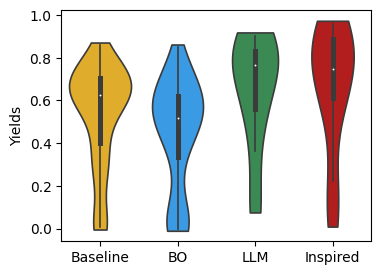

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 假设 human_df, bo_df 和 expert_df 已经存在

# 获取数据
baseline_yield = baseline_df['yield'].values
bo_yield = bo_df['yield'].values
llm_yield = llm_df['yield'].values
inspired_yield = inspired_df['yield'].values

data = [baseline_yield, bo_yield, llm_yield, inspired_yield]
labels = ["Baseline", "BO", "LLM", "Inspired"]
colors = ['#FEB90D', '#1E9EFF', '#2E974E', '#CB0505']

# 画violin plot
plt.figure(figsize=(4, 3))
sns.violinplot(data=data, inner="box", linewidth=1.2, cut=0.1, palette=colors)
# plt.ylim(0, 1)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.ylabel("Yields")
# plt.title("Violin Plot of Yields among Baseline, BO, LLM and Expert Groups")
plt.savefig("violin_plot.png", dpi=1000, bbox_inches='tight')
plt.show()

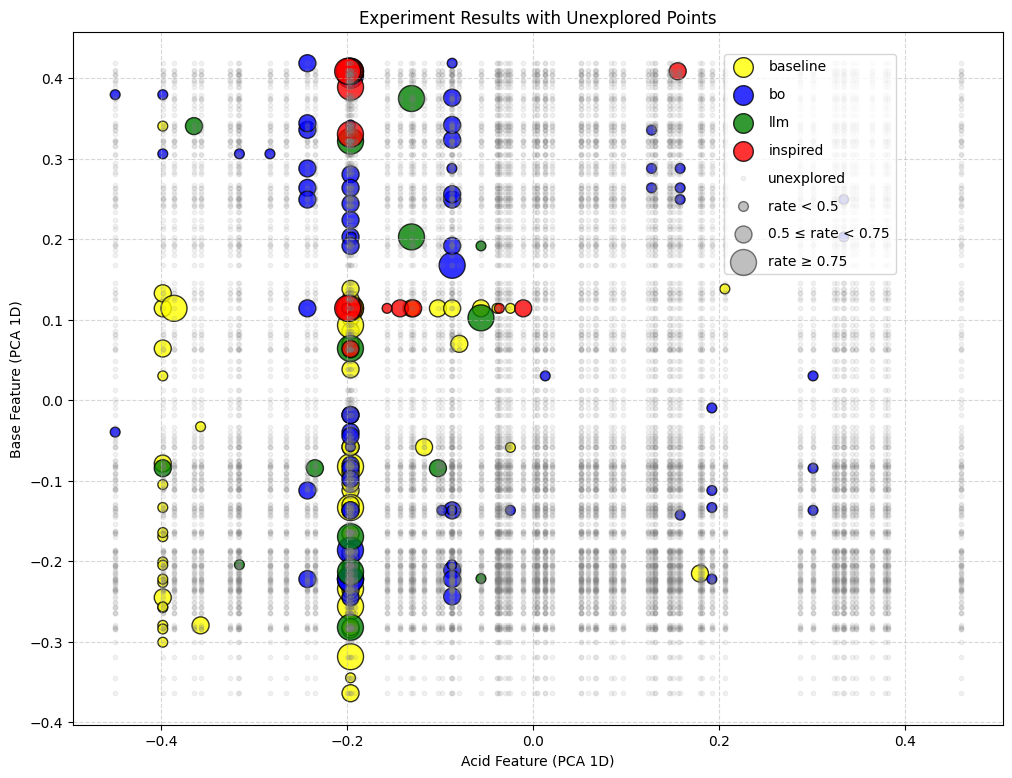

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import itertools

# 定义一个函数，从 all_table 中获取特征向量，并转换为 numpy 数组
def get_feature_vector(name):
    return np.array(all_table[name])

def get_all_possible_combinations():
    avail_acid_info = pd.read_excel('../src/data/acid.xlsx')['name'].tolist()
    avail_base_info = pd.read_excel('../src/data/base.xlsx')['name'].tolist()
    
    avail_acid_info = [acid for acid in avail_acid_info if acid in all_table.keys()]
    avail_base_info = [base for base in avail_base_info if base in all_table.keys()]

    experiment_dfs = [baseline_df, bo_df, llm_df, inspired_df]
    for df in experiment_dfs:
        for i in range(len(df)):
            row = df.iloc[i]
            if row['acid'] not in avail_acid_info:
                avail_acid_info.append(row['acid']) 
            if row['base'] not in avail_base_info:
                avail_base_info.append(row['base']) 
    
    return list(itertools.product(avail_acid_info, avail_base_info)), avail_acid_info, avail_base_info

all_combinations, avail_acid_info, avail_base_info = get_all_possible_combinations()
# 处理未探索的实验点
all_combinations = set(all_combinations)

# 提取已有实验的特征向量和标签
experiment_dfs = [baseline_df, bo_df, llm_df, inspired_df]
existing_combinations = set()
unexplored_combinations = all_combinations - existing_combinations

acid_features, base_features = [], []
acid_pca_dict = {}
base_pca_dict = {}

for acid in avail_acid_info:
    acid_features.append(get_feature_vector(acid).tolist())

for base in avail_base_info:
    base_features.append(get_feature_vector(base).tolist())

acid_features = np.array(acid_features)
base_features = np.array(base_features)

# PCA降维
pca_acid = PCA(n_components=1)
pca_base = PCA(n_components=1)
              
acid_pca_values = pca_acid.fit_transform(acid_features).flatten()
base_pca_values = pca_base.fit_transform(base_features).flatten()

for pca, acid in zip(acid_pca_values, avail_acid_info):
    acid_pca_dict[acid] = pca
for pca, base in zip(base_pca_values, avail_base_info):
    base_pca_dict[base] = pca

def add_pca_to_df(df):
    df['acid_pca'] = df['acid'].apply(lambda x: acid_pca_dict[x])
    df['base_pca'] = df['base'].apply(lambda x: base_pca_dict[x])
    return df

baseline_df = add_pca_to_df(baseline_df)
bo_df = add_pca_to_df(bo_df)
llm_df = add_pca_to_df(llm_df)
inspired_df = add_pca_to_df(inspired_df)

unexplored_combinations = list(unexplored_combinations)
unexplored_acid = [pair[0] for pair in unexplored_combinations]
unexplored_base = [pair[1] for pair in unexplored_combinations]

unexplored_df = pd.DataFrame([])
unexplored_df['acid'] = unexplored_acid
unexplored_df['base'] = unexplored_base
unexplored_df['yield'] = 0

unexplored_df = add_pca_to_df(unexplored_df)


# 根据rate定义离散的点大小
def discrete_size(rate):
    if rate < 0.5:
        return 50
    elif rate < 0.75:
        return 150
    else:
        return 350

# 应用到DataFrame中
for df in [baseline_df, bo_df, llm_df, inspired_df]:
    df['size'] = df['yield'].apply(discrete_size)



# 绘图
plt.figure(figsize=(12, 9))
colors = {'baseline': 'yellow', 'bo': 'blue', 'llm': 'green', 'inspired': 'red'}

# 已有实验点
for df, label in zip(experiment_dfs, ['baseline', 'bo', 'llm', 'inspired']):
    plt.scatter(df['acid_pca'], df['base_pca'], s=df['size'], c=colors[label], edgecolors='k', label=label, alpha=0.8)

# 未探索的实验点
plt.scatter(unexplored_df.acid_pca, unexplored_df.base_pca, s=10, c='gray', alpha=0.1, label='unexplored')

# 图例示意点
for size, rate_label in zip([50, 150, 350], ['rate < 0.5', '0.5 ≤ rate < 0.75', 'rate ≥ 0.75']):
    plt.scatter([], [], s=size, c='gray', alpha=0.5, edgecolors='k', label=rate_label)

plt.xlabel('Acid Feature (PCA 1D)')
plt.ylabel('Base Feature (PCA 1D)')
plt.title('Experiment Results with Unexplored Points')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, loc=(0.7, 0.65))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

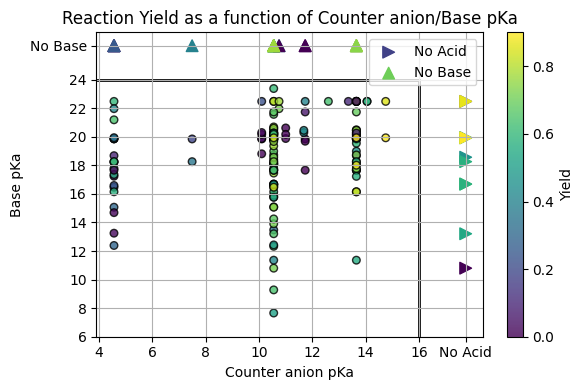

In [5]:
all_data = pd.concat([baseline_df, bo_df, llm_df, inspired_df])

acid = pd.read_excel(os.path.join(BASE_DIR, 'acids_pka.xlsx'), index_col=0)
base = pd.read_excel(os.path.join(BASE_DIR, 'bases_pka.xlsx'), index_col=0)

acid_pka = []
base_pka = []
yields = []

for i in range(len(all_data)):
    row = all_data.iloc[i]
    # print(acid[acid['acid'] == row['acid']])
    acid_slice = acid[acid['acid'] == row['acid']].reset_index(drop=True)
    base_slice = base[base['base'] == row['base']].reset_index(drop=True)
    try:
        if len(acid_slice) != 0 and len(base_slice) != 0:
            acid_pka.append(acid_slice['MeOH'][0])
            base_pka.append(base_slice['MeOH'][0])
            yields.append(row['yield'])
        elif len(acid_slice) == 0:
            acid_pka.append(0)
            base_pka.append(base_slice['MeOH'][0])
            yields.append(row['yield'])
        elif len(base_slice) == 0:
            acid_pka.append(acid_slice['MeOH'][0])
            base_pka.append(0)
            yields.append(row['yield'])
    except:
        print(row)

acid_pka = np.array(acid_pka)
base_pka = np.array(base_pka)
yields = np.array(yields)

condition = (acid_pka != 0) & (base_pka != 0)

# 根据条件筛选出新的数组
acid_pka_filtered = acid_pka[condition]
base_pka_filtered = base_pka[condition]
yields_filtered = yields[condition]

mask_zero_acid = acid_pka == 0
mask_zero_base = base_pka == 0

n_acid = max(acid_pka) + 3
n_base = max(base_pka) + 3

acid_pka[mask_zero_acid] = max(acid_pka) + 3
base_pka[mask_zero_base] = max(base_pka) + 3


from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle

# 创建散点图
plt.figure(figsize=(6, 4))
scatter = plt.scatter(acid_pka_filtered, base_pka_filtered, c=yields_filtered, cmap='viridis', s=30, edgecolor='k', alpha=0.8)
plt.colorbar(scatter, label='Yield')

# 设置轴标签和标题
plt.xlabel('Counter anion pKa')
plt.ylabel('Base pKa')
plt.title('Reaction Yield as a function of Counter anion/Base pKa')

# plt.xlim(2, np.max(acid_pka) - 2)
# plt.ylim(5, np.max(base_pka) - 2)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='upper'))  # 上限剪切
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='upper'))  # 上限剪切

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', steps=[1, 2, 4]))  # 步长设置为4
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', steps=[1, 2, 4]))  # 步长设置为4

current_xticks = plt.gca().get_xticks()
current_xticks = np.append(current_xticks, 16)

current_yticks = plt.gca().get_yticks()

# 只在 x=20 和 y=20 上添加特殊标签 "No Acid" 和 "No Base"
xticks_labels = [str(int(tick)) for tick in current_xticks] + ['No Acid']  # 默认刻度标签
yticks_labels = [str(int(tick)) for tick in current_yticks] + ['No Base']  # 默认刻度标签

current_xticks = np.append(current_xticks, n_acid)
current_yticks = np.append(current_yticks, n_base)

# 标记原本为0的点，并将它们放置到图外（坐标轴右侧和上方）

plt.scatter(acid_pka[mask_zero_acid], base_pka[mask_zero_acid], c=yields[mask_zero_acid], s=70, marker='>', label="No Acid")
plt.scatter(acid_pka[mask_zero_base], base_pka[mask_zero_base], c=yields[mask_zero_base], s=70, marker='^', label="No Base")

# plt.xticks(ticks=[n_acid], labels=["No Acid"])  # 设置 x 轴上 20 的位置显示 "No Acid"
# plt.yticks(ticks=[n_base], labels=["No Base"])  # 设置 y 轴上 20 的位置显示 "No Base"

# 替换特定位置的标签
plt.xticks(current_xticks, xticks_labels)
plt.yticks(current_yticks, yticks_labels)

ax = plt.gca()

# 在横坐标16和纵坐标24的位置绘制一个矩形框
rect = Rectangle((0, 0), 16, 24, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig("pka_distribution.png", dpi=1000, bbox_inches='tight')
plt.show()


C:\Users\darkn\AppData\Local\Temp\ipykernel_9680\1122444056.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


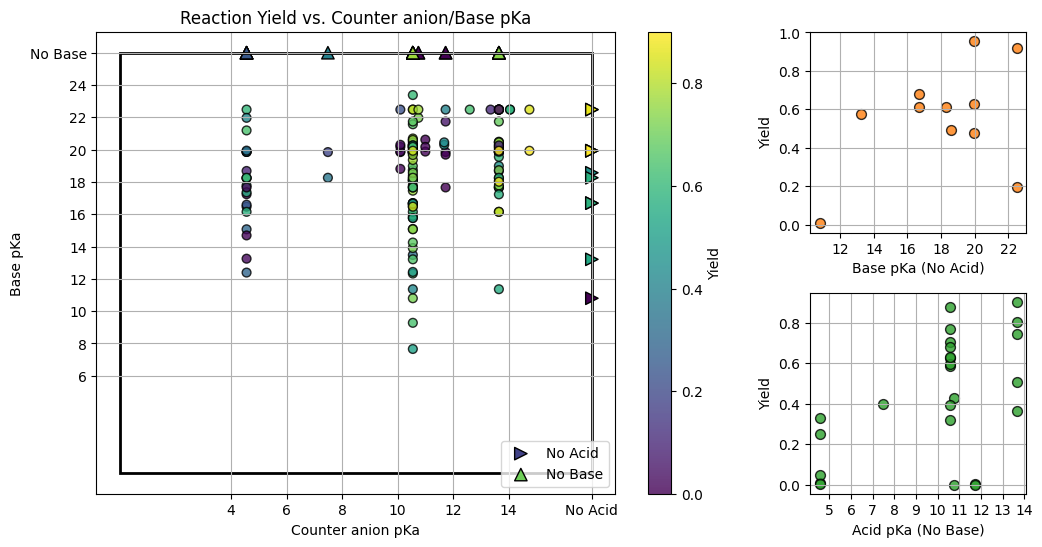

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

# ========== 1. 读取并处理数据 ==========

all_data = pd.concat([baseline_df, bo_df, llm_df, inspired_df])

acid = pd.read_excel(os.path.join(BASE_DIR, 'acids_pka.xlsx'), index_col=0)
base = pd.read_excel(os.path.join(BASE_DIR, 'bases_pka.xlsx'), index_col=0)

acid_pka = []
base_pka = []
yields = []

for i in range(len(all_data)):
    row = all_data.iloc[i]
    acid_slice = acid[acid['acid'] == row['acid']].reset_index(drop=True)
    base_slice = base[base['base'] == row['base']].reset_index(drop=True)
    try:
        if len(acid_slice) != 0 and len(base_slice) != 0:
            acid_pka.append(acid_slice['MeOH'][0])
            base_pka.append(base_slice['MeOH'][0])
            yields.append(row['yield'])
        elif len(acid_slice) == 0:  # 只有碱
            acid_pka.append(0)
            base_pka.append(base_slice['MeOH'][0])
            yields.append(row['yield'])
        elif len(base_slice) == 0:  # 只有酸
            acid_pka.append(acid_slice['MeOH'][0])
            base_pka.append(0)
            yields.append(row['yield'])
    except:
        print("处理出错的行:", row)

acid_pka = np.array(acid_pka)
base_pka = np.array(base_pka)
yields = np.array(yields)

# 筛出既有酸又有碱的“配对”数据
condition = (acid_pka != 0) & (base_pka != 0)
acid_pka_pair   = acid_pka[condition]
base_pka_pair   = base_pka[condition]
yields_pair     = yields[condition]

# 找出“只有碱”（acid_pka==0） 和 “只有酸”（base_pka==0）
mask_only_base = (acid_pka == 0)
mask_only_acid = (base_pka == 0)

# 在主图框内部，我们希望把“只有酸/碱”的点移到框外，用n_acid/n_base来表示
n_acid = int(max(acid_pka) + 3)
n_base = int(max(base_pka) + 3)
acid_pka[mask_only_base] = n_acid   # “只有碱” 这类，把 x 坐标设为 n_acid
base_pka[mask_only_acid] = n_base   # “只有酸” 这类，把 y 坐标设为 n_base

# ========== 2. 创建 Figure 和 GridSpec 布局 ==========
# 我们想要左边一个“酸–碱对”散点图，占据两行；
# 右边上面一个子图画“只有碱”点；右边下面一个子图画“只有酸”点。
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(
    nrows=2, ncols=2,
    width_ratios=[3, 1],   # 左图宽度是右边任一子图宽度的 3 倍
    height_ratios=[1, 1],  # 右边两个子图高度相等
    wspace=0.15,           # 左右子图之间的水平间距
    hspace=0.3             # 右边上下子图之间的垂直间距
)

# ———— 左侧主图（酸–碱对散点图） ————
ax_main = fig.add_subplot(gs[:, 0])  # 占据第一列的两行（gs[0:2, 0]）
scatter = ax_main.scatter(
    acid_pka_pair, base_pka_pair,
    c=yields_pair, cmap='viridis', s=40, edgecolor='k', alpha=0.8
)
cbar = plt.colorbar(scatter, ax=ax_main, label='Yield')
ax_main.set_xlabel('Counter anion pKa')
ax_main.set_ylabel('Base pKa')
ax_main.set_title('Reaction Yield vs. Counter anion/Base pKa')

# 设置主图的刻度：仅在整数处打刻度，并且强制把 n_acid 和 n_base 加到刻度里
ax_main.xaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', steps=[1, 2, 4]))
ax_main.yaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', steps=[1, 2, 4]))

# 先拿到当前刻度
xticks = list(ax_main.get_xticks())
yticks = list(ax_main.get_yticks())
# 再把 “没有酸” 和 “没有碱” 的标识刻度加进去
xticks.append(n_acid)
yticks.append(n_base)

# 构造新的标签列表：原来的数字标签 + 特殊标签
xticks_labels = [str(int(t)) for t in ax_main.get_xticks()] + ['No Acid']
yticks_labels = [str(int(t)) for t in ax_main.get_yticks()] + ['No Base']

ax_main.set_xticks(xticks)
ax_main.set_xticklabels(xticks_labels)
ax_main.set_yticks(yticks)
ax_main.set_yticklabels(yticks_labels)

# 把“只有酸/碱”的点分别画到主图的边缘位置，用箭头标记
ax_main.scatter(
    acid_pka[mask_only_base], base_pka[mask_only_base],
    c=yields[mask_only_base], s=80, marker='>', edgecolor='k', label='No Acid'
)
ax_main.scatter(
    acid_pka[mask_only_acid], base_pka[mask_only_acid],
    c=yields[mask_only_acid], s=80, marker='^', edgecolor='k', label='No Base'
)

# 在 (0,0)-(n_acid,n_base) 区域画一个边框，表示“酸–碱配对区”
rect = Rectangle((0, 0), n_acid, n_base, linewidth=2, edgecolor='black', facecolor='none')
ax_main.add_patch(rect)

ax_main.grid(True)
ax_main.legend(loc='lower right')

# ———— 右上子图：只画“只有碱”（acid_pka==0）这部分数据  ————
ax_top = fig.add_subplot(gs[0, 1])
# 横坐标： base_pka（在 mask_only_base 部分），纵坐标：yield
ax_top.scatter(
    base_pka[mask_only_base], yields[mask_only_base],
    color='tab:orange', edgecolor='k', alpha=0.8, s=50
)
ax_top.set_xlabel('Base pKa (No Acid)')
ax_top.set_ylabel('Yield')
# ax_top.set_title('Only Base Catalysts', fontsize=10)
ax_top.xaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', steps=[1, 2, 4]))
ax_top.grid(True)

# ———— 右下子图：只画“只有酸”（base_pka==0）这部分数据  ————
ax_bottom = fig.add_subplot(gs[1, 1])
# 横坐标： acid_pka（在 mask_only_acid 部分），纵坐标：yield
ax_bottom.scatter(
    acid_pka[mask_only_acid], yields[mask_only_acid],
    color='tab:green', edgecolor='k', alpha=0.8, s=50
)
ax_bottom.set_xlabel('Acid pKa (No Base)')
ax_bottom.set_ylabel('Yield')
# ax_bottom.set_title('Only Acid Catalysts', fontsize=10)
ax_bottom.xaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', steps=[1, 2, 4]))
ax_bottom.grid(True)

# ========== 3. 调整布局并保存/展示 ==========
plt.tight_layout()
plt.savefig("pka_distribution_with_subplots.png", dpi=800, bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\darkn\AppData\Local\Temp\ipykernel_9680\3454279749.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


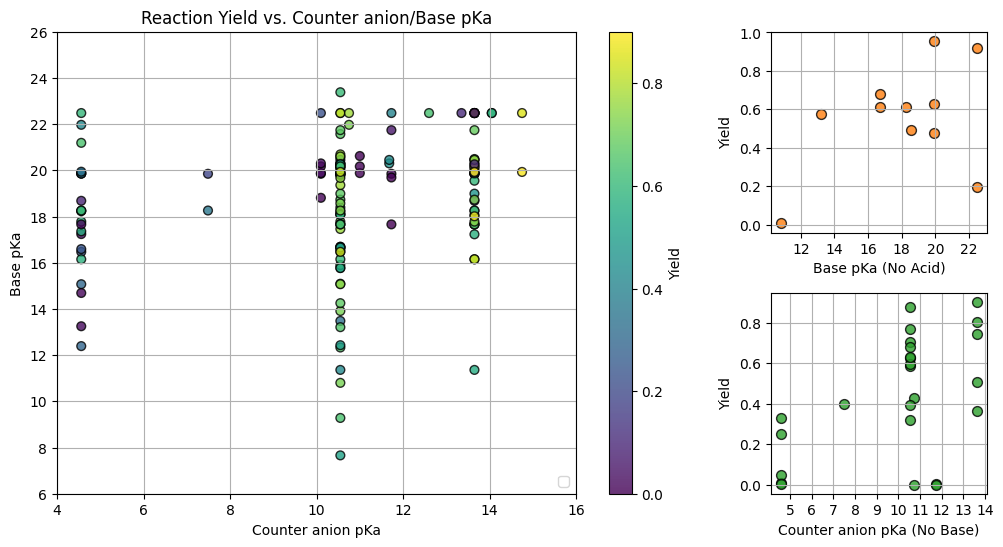

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

# ========== 1. 读取并处理数据 ==========

all_data = pd.concat([baseline_df, bo_df, llm_df, inspired_df])

acid = pd.read_excel(os.path.join(BASE_DIR, 'acids_pka.xlsx'), index_col=0)
base = pd.read_excel(os.path.join(BASE_DIR, 'bases_pka.xlsx'), index_col=0)

acid_pka = []
base_pka = []
yields = []

for i in range(len(all_data)):
    row = all_data.iloc[i]
    acid_slice = acid[acid['acid'] == row['acid']].reset_index(drop=True)
    base_slice = base[base['base'] == row['base']].reset_index(drop=True)
    try:
        if len(acid_slice) != 0 and len(base_slice) != 0:
            acid_pka.append(acid_slice['MeOH'][0])
            base_pka.append(base_slice['MeOH'][0])
            yields.append(row['yield'])
        elif len(acid_slice) == 0:  # 只有碱
            acid_pka.append(0)
            base_pka.append(base_slice['MeOH'][0])
            yields.append(row['yield'])
        elif len(base_slice) == 0:  # 只有酸
            acid_pka.append(acid_slice['MeOH'][0])
            base_pka.append(0)
            yields.append(row['yield'])
    except:
        print("处理出错的行:", row)

acid_pka = np.array(acid_pka)
base_pka = np.array(base_pka)
yields = np.array(yields)

# 筛出既有酸又有碱的“配对”数据
condition = (acid_pka != 0) & (base_pka != 0)
acid_pka_pair   = acid_pka[condition]
base_pka_pair   = base_pka[condition]
yields_pair     = yields[condition]

# 找出“只有碱”（acid_pka==0） 和 “只有酸”（base_pka==0）
mask_only_base = (acid_pka == 0)
mask_only_acid = (base_pka == 0)

# 在主图框内部，我们希望把“只有酸/碱”的点移到框外，用n_acid/n_base来表示
n_acid = int(max(acid_pka) + 3)
n_base = int(max(base_pka) + 3)
acid_pka[mask_only_base] = n_acid   # “只有碱” 这类，把 x 坐标设为 n_acid
base_pka[mask_only_acid] = n_base   # “只有酸” 这类，把 y 坐标设为 n_base

# ========== 2. 创建 Figure 和 GridSpec 布局 ==========
# 我们想要左边一个“酸–碱对”散点图，占据两行；
# 右边上面一个子图画“只有碱”点；右边下面一个子图画“只有酸”点。
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(
    nrows=2, ncols=2,
    width_ratios=[3, 1],   # 左图宽度是右边任一子图宽度的 3 倍
    height_ratios=[1, 1],  # 右边两个子图高度相等
    wspace=0.15,           # 左右子图之间的水平间距
    hspace=0.3             # 右边上下子图之间的垂直间距
)

# ———— 左侧主图（酸–碱对散点图） ————
ax_main = fig.add_subplot(gs[:, 0])  # 占据第一列的两行（gs[0:2, 0]）
scatter = ax_main.scatter(
    acid_pka_pair, base_pka_pair,
    c=yields_pair, cmap='viridis', s=40, edgecolor='k', alpha=0.8
)
cbar = plt.colorbar(scatter, ax=ax_main, label='Yield')
ax_main.set_xlabel('Counter anion pKa')
ax_main.set_ylabel('Base pKa')
ax_main.set_title('Reaction Yield vs. Counter anion/Base pKa')

# 先拿到当前刻度
xticks = list(ax_main.get_xticks())
yticks = list(ax_main.get_yticks())
# 再把 “没有酸” 和 “没有碱” 的标识刻度加进去

# 构造新的标签列表：原来的数字标签 + 特殊标签
xticks_labels = [str(int(t)) for t in ax_main.get_xticks()]
yticks_labels = [str(int(t)) for t in ax_main.get_yticks()]

ax_main.set_xticks(xticks)
ax_main.set_xticklabels(xticks_labels)
ax_main.set_yticks(yticks)
ax_main.set_yticklabels(yticks_labels)

ax_main.grid(True)

# ———— 右上子图：只画“只有碱”（acid_pka==0）这部分数据  ————
ax_top = fig.add_subplot(gs[0, 1])
# 横坐标： base_pka（在 mask_only_base 部分），纵坐标：yield
ax_top.scatter(
    base_pka[mask_only_base], yields[mask_only_base],
    color='tab:orange', edgecolor='k', alpha=0.8, s=50
)
ax_top.set_xlabel('Base pKa (No Acid)')
ax_top.set_ylabel('Yield')
# ax_top.set_title('Only Base Catalysts', fontsize=10)
ax_top.xaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', steps=[1, 2, 4]))
ax_top.grid(True)

# ———— 右下子图：只画“只有酸”（base_pka==0）这部分数据  ————
ax_bottom = fig.add_subplot(gs[1, 1])
# 横坐标： acid_pka（在 mask_only_acid 部分），纵坐标：yield
ax_bottom.scatter(
    acid_pka[mask_only_acid], yields[mask_only_acid],
    color='tab:green', edgecolor='k', alpha=0.8, s=50
)
ax_bottom.set_xlabel('Counter anion pKa (No Base)')
ax_bottom.set_ylabel('Yield')
# ax_bottom.set_title('Only Acid Catalysts', fontsize=10)
ax_bottom.xaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', steps=[1, 2, 4]))
ax_bottom.grid(True)

# ========== 3. 调整布局并保存/展示 ==========
plt.tight_layout()
plt.savefig("pka_distribution_with_subplots.png", dpi=800, bbox_inches='tight')
plt.show()

C:\Users\darkn\AppData\Local\Temp\ipykernel_9680\1470621937.py:182: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


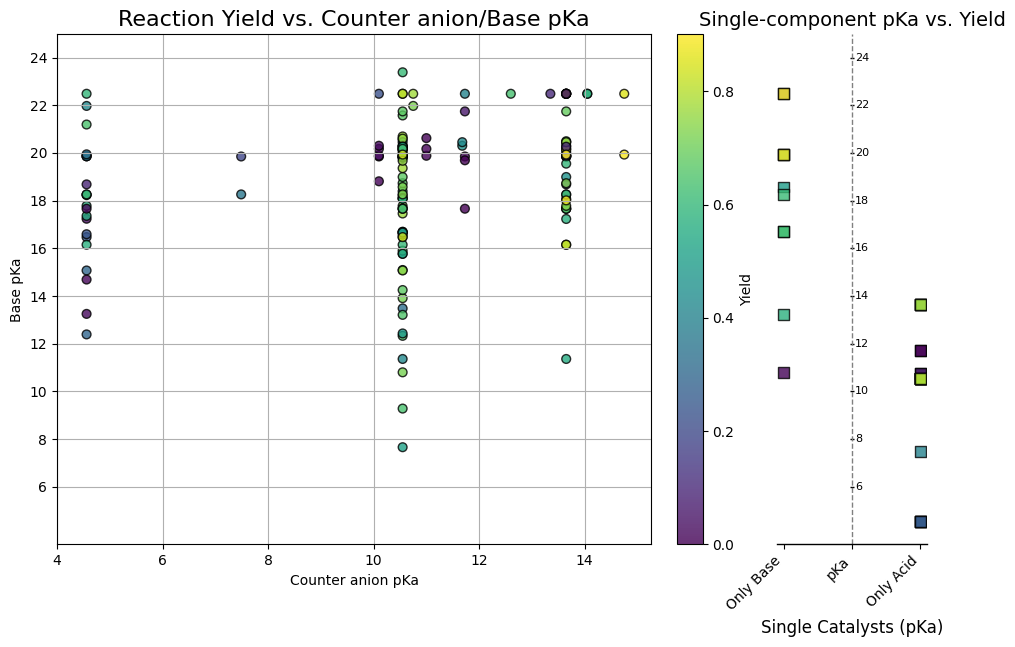

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import Normalize

# ========== 1. 读取并处理数据 ==========
# （假设 baseline_df, bo_df, llm_df, inspired_df, BASE_DIR 都在作用域里）

all_data = pd.concat([baseline_df, bo_df, llm_df, inspired_df])

acid = pd.read_excel(os.path.join(BASE_DIR, 'acids_pka.xlsx'), index_col=0)
base = pd.read_excel(os.path.join(BASE_DIR, 'bases_pka.xlsx'), index_col=0)

acid_pka = []
base_pka = []
yields  = []

for i in range(len(all_data)):
    row = all_data.iloc[i]
    acid_slice = acid[acid['acid'] == row['acid']].reset_index(drop=True)
    base_slice = base[base['base'] == row['base']].reset_index(drop=True)
    try:
        if len(acid_slice) != 0 and len(base_slice) != 0:
            acid_pka.append(acid_slice['MeOH'][0])
            base_pka.append(base_slice['MeOH'][0])
            yields.append(row['yield'])
        elif len(acid_slice) == 0:   # 只有碱
            acid_pka.append(0)
            base_pka.append(base_slice['MeOH'][0])
            yields.append(row['yield'])
        elif len(base_slice) == 0:   # 只有酸
            acid_pka.append(acid_slice['MeOH'][0])
            base_pka.append(0)
            yields.append(row['yield'])
    except:
        print("处理出错的行:", row)

acid_pka = np.array(acid_pka)
base_pka = np.array(base_pka)
yields   = np.array(yields)

# “既有酸又有碱”的配对
mask_pair      = (acid_pka != 0) & (base_pka != 0)
acid_pka_pair  = acid_pka[mask_pair]
base_pka_pair  = base_pka[mask_pair]
yields_pair    = yields[mask_pair]

# “只有碱” & “只有酸” 的掩码
mask_only_base = (acid_pka == 0)
mask_only_acid = (base_pka == 0)

# 设一个“框外”位置 n_acid / n_base，主要是为了在主图里把这些点画到边缘
n_acid = int(max(acid_pka) + 3)
n_base = int(max(base_pka) + 3)
acid_pka[mask_only_base] = n_acid   # 只有碱的，x 坐标赋为 n_acid
base_pka[mask_only_acid] = n_base   # 只有酸的，y 坐标赋为 n_base


# ========== 2. 创建 Figure 和 左侧主图 ==========
fig = plt.figure(figsize=(10, 6))
# 左侧主图占大部分空间
ax_main = fig.add_axes([0.05, 0.1, 0.65, 0.85])  
# [left, bottom, width, height] 都是 0~1 的归一化坐标

# —— 在 ax_main 上画“酸–碱对”散点 ——  
# 我们先取出配对数据，按 yield 上色，使用 viridis
cmap = plt.cm.viridis
norm = Normalize(vmin=yields_pair.min(), vmax=yields_pair.max())

scatter = ax_main.scatter(
    acid_pka_pair, base_pka_pair,
    c=yields_pair, cmap=cmap, norm=norm,
    s=40, edgecolor='k', alpha=0.8
)
# 把 colorbar 画到主图右侧
cbar = fig.colorbar(scatter, ax=ax_main, label='Yield', fraction=0.046, pad=0.04)

ax_main.set_xlabel('Counter anion pKa')
ax_main.set_ylabel('Base pKa')
ax_main.set_title('Reaction Yield vs. Counter anion/Base pKa', fontsize=16)

# 设置整数刻度，先取默认刻度，再在末尾留一点空白给“n_acid/n_base”
ax_main.xaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', steps=[1,2,4]))
ax_main.yaxis.set_major_locator(MaxNLocator(integer=True, prune='upper', steps=[1,2,4]))
xticks = list(ax_main.get_xticks()); yticks = list(ax_main.get_yticks())
xticklabels = [str(int(t)) for t in ax_main.get_xticks()]
yticklabels = [str(int(t)) for t in ax_main.get_yticks()]
ax_main.set_xticks(xticks); ax_main.set_xticklabels(xticklabels)
ax_main.set_yticks(yticks); ax_main.set_yticklabels(yticklabels)

ax_main.grid(True)

# ========== 3. 右侧竖直色带 (ax_strip)，共享 ax_main 的 y 轴 ==========
# 我们想把它放在 figure 的右边，大致在 (x=0.77 ~ 0.95) 区域
# 左下角坐标(0.77, 0.1)，宽度 0.15，高度 0.85：
ax_strip = fig.add_axes([0.77, 0.1, 0.15, 0.85], sharey=ax_main)

# 在这条竖直色带上，分别画“只有碱” & “只有酸”两种点
# 让 x 轴上两个值：0 表示“只有碱”这一组，1 表示“只有酸”这一组
x_base = np.zeros(np.sum(mask_only_base))   # 全 0
y_base = base_pka[mask_only_base]           # 它们的 base pKa
c_base = yields[mask_only_base]             # 它们对应的 yield

x_acid = np.ones(np.sum(mask_only_acid))    # 全 1
y_acid = acid_pka[mask_only_acid]           # 它们的 acid pKa
c_acid = yields[mask_only_acid]             # 它们对应的 yield

# 画“只有碱”点：x=0，y=[base_pka]，颜色映射 c_base
ax_strip.scatter(
    x_base, y_base,
    c=c_base, cmap=cmap, norm=norm,
    s=60, edgecolor='k', marker='s', alpha=0.8,
    label='Only Base'
)
# 画“只有酸”点：x=1，y=[acid_pka]，颜色映射 c_acid
ax_strip.scatter(
    x_acid, y_acid,
    c=c_acid, cmap=cmap, norm=norm,
    s=60, edgecolor='k', marker='s', alpha=0.8,
    label='Only Acid'
)

# ====== 在虚线上添加刻度 ======
# 1. 先拿到想要标记的 y 位置（这里用当前的 y 轴刻度）
yticks = ax_strip.get_yticks()

# 2. 设定刻度线在 x=0.5 两边的偏移量（这个数值可以自己调节刻度线的长度）
dx = 0.015  # 代表在 x=0.5 左右各 0.015 个数据单位画短线

# 3. 利用 hlines 一次性把所有短刻度都画出来
for y in yticks:
    ax_strip.hlines(
        y=y,
        xmin=0.5 - dx,
        xmax=0.5 + dx,
        color='black',
        linewidth=1
    )

# ===== 在虚线上添加刻度标签 =====
# 把刻度标签文字放到 x=0.5+偏移 的位置
# 这里稍微让文字往右移一点（dx*1.5），并保证垂直居中对齐
for y in yticks:
    ax_strip.text(
        0.5 + dx*1.5,  # x 位置：虚线 + 偏移
        y,             # y 位置：刻度所在 pKa 值
        str(int(y)),   # 文本标签：把 y 转成整数字符串
        va='center',   # 垂直居中
        ha='left',     # 左对齐
        fontsize=8
    )

# 隐藏 ax_strip 的 y 轴标签（它跟左侧共用 y 轴，不需要重复）
ax_strip.set_ylabel('')
ax_strip.tick_params(axis='y', which='both', left=False, labelleft=False)

# x 轴上只显示两个刻度：0 和 1，改成文字标签“Only Base”和“No Base”之类
ax_strip.set_xticks([0, 0.5, 1])
ax_strip.set_xticklabels(['Only Base', 'pKa', 'Only Acid'], fontsize=10, rotation=45, ha='right')
ax_strip.set_xlabel('Single Catalysts (pKa)', fontsize=12)

# 为了好看，可以给 ax_strip 加个标题，指定 fontsize
ax_strip.set_title('Single-component pKa vs. Yield', fontsize=14)

# 画一条竖直参考线在 x=0.5，让视觉上更像一条“中间轴”
ax_strip.axvline(0.5, color='gray', linestyle='--', linewidth=1)

# 去掉 top/right 边框，把 bottom 边框加粗一点
ax_strip.spines['top'].set_visible(False)
ax_strip.spines['right'].set_visible(False)
ax_strip.spines['left'].set_visible(False)
ax_strip.spines['bottom'].set_linewidth(1.0)

# Shared y 轴跟 ax_main 对齐，会自动沿用 ax_main 的 y 轴范围和刻度
ax_strip.set_ylim(ax_main.get_ylim())
ax_strip.set_yticks(ax_main.get_yticks())

# ========== 4. 展示并保存 ==========
plt.tight_layout()
plt.savefig("pka_with_one_vertical_strip.png", dpi=800, bbox_inches='tight')
plt.show()
